In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import ast
from pymongo import MongoClient

In [2]:
def start_spark():
    return SparkSession.builder \
        .appName("CafeRecommendation") \
        .config("spark.mongodb.input.uri", "mongodb://localhost:27017/cafe_db.cafe_data") \
        .config("spark.mongodb.output.uri", "mongodb://localhost:27017/cafe_db.cafe_data") \
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.executor.cores", "2") \
        .config("spark.executor.instances", "4") \
        .master("local[*]") \
        .getOrCreate()

In [3]:
spark = start_spark()
print(spark)

In [4]:
df = spark.read.format("mongo").load()
df = df.repartition(2)
df.show()

+--------------------+---+---+------+--------------------+--------+-------+--------------+----------+--------------------+--------------------+---------------+-------------+---------------+------------+-------------+--------------------+--------------------+-------------------+-------------+--------------------+
|                 _id| ac|bar|  city|            cuisines|delivery|dine_in|establishments|live_music|            locality|                name|outdoor_seating|price_for_two|ratings_average|ratings_text|ratings_votes|             reviews|  sentiment_negative| sentiment_positive|serves_nonveg|                 url|
+--------------------+---+---+------+--------------------+--------+-------+--------------+----------+--------------------+--------------------+---------------+-------------+---------------+------------+-------------+--------------------+--------------------+-------------------+-------------+--------------------+
|{67025c9104ba385b...|  0|  0|Mumbai|                Cafe|

In [5]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- ac: integer (nullable = true)
 |-- bar: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- cuisines: string (nullable = true)
 |-- delivery: integer (nullable = true)
 |-- dine_in: integer (nullable = true)
 |-- establishments: integer (nullable = true)
 |-- live_music: integer (nullable = true)
 |-- locality: string (nullable = true)
 |-- name: string (nullable = true)
 |-- outdoor_seating: integer (nullable = true)
 |-- price_for_two: integer (nullable = true)
 |-- ratings_average: double (nullable = true)
 |-- ratings_text: string (nullable = true)
 |-- ratings_votes: integer (nullable = true)
 |-- reviews: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- description: string (nullable = true)
 |-- sentiment_negative: double (nullable = true)
 |-- sentiment_positive: double (nullable = true)
 |-- ser

In [6]:
df_pd = df.toPandas()

In [7]:
spark.stop()

Analyse Top Cuisines

In [8]:
df_pd['cuisines'] = df_pd['cuisines'].str.split(', ')
cuisines_exploded = df_pd.explode('cuisines')
top_cuisines = cuisines_exploded['cuisines'].value_counts().head(10)

C:\Users\ama.D.eus\AppData\Local\Temp\ipykernel_17420\1786936534.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cuisines.index, y=top_cuisines.values, palette='viridis')


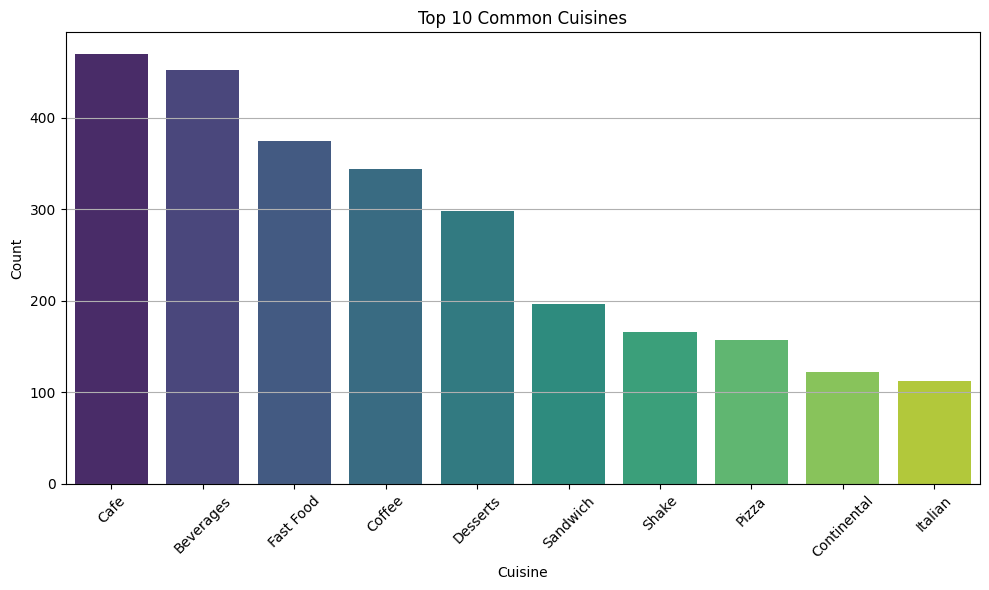

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_cuisines.index, y=top_cuisines.values, palette='viridis')
plt.title('Top 10 Common Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [10]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ama.D.eus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ama.D.eus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ama.D.eus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Creating a dictionary where keys are restaurant names and values are lists of review descriptions
restaurant_reviews = {row['name']: [review['description'] for review in row['reviews']] for _, row in df_pd.iterrows()}

In [12]:
def analyze_sentiment(review):
    if pd.isna(review) or review.lower() == 'n/a':
        return 0.0, 0.0
    scores = sid.polarity_scores(review)
    return scores['pos'], scores['neg']

In [13]:
restaurant_sentiments = {}
for name, reviews in restaurant_reviews.items():
    if not reviews:  
        restaurant_sentiments[name] = [(0.0, 0.0)]
    else:
        sentiments = [analyze_sentiment(review) for review in reviews]
        restaurant_sentiments[name] = sentiments

In [14]:
sentiment_positive = []
sentiment_negative = []

In [15]:
for name in df_pd['name']:
    # Get the sentiments for the restaurant
    sentiments = restaurant_sentiments.get(name, [(0.0, 0.0)])  # Default to (0.0, 0.0) if not found
    avg_positive = sum(score[0] for score in sentiments) / len(sentiments)  # Average positive score
    avg_negative = sum(score[1] for score in sentiments) / len(sentiments)  # Average negative score
    
    sentiment_positive.append(avg_positive)
    sentiment_negative.append(avg_negative)

# Add sentiment columns to the DataFrame
df_pd['sentiment_positive'] = sentiment_positive
df_pd['sentiment_negative'] = sentiment_negative

In [16]:
client = MongoClient('mongodb://localhost:27017/')
db = client['cafe_db']
collection = db['cafe_data']

for index, row in df_pd.iterrows():
    filter_condition = {'name': row['name']} 

    update_operation = {
        '$set': {
            'sentiment_positive': row['sentiment_positive'],
            'sentiment_negative': row['sentiment_negative']
        }
    }
    collection.update_one(filter_condition, update_operation)

print("Sentiment values updated in MongoDB based on restaurant names.")

Sentiment values updated in MongoDB based on restaurant names.


Mostly Used Positive Sentiment Words in User Reviews

In [17]:
def classify_sentiment(score):
    if score is None:
        return 'neutral'
    elif score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

In [18]:
from collections import Counter
df_pd['positive_scores'] = df_pd['reviews'].apply(lambda x: [analyze_sentiment(desc[1]) for desc in x if len(desc) > 1])
positive_reviews = df_pd['reviews'].explode().dropna().tolist()
positive_reviews_text = [desc[1] for desc in positive_reviews]

In [19]:
positive_words = []
for review in positive_reviews_text:
    words = word_tokenize(review.lower())
    positive_words.extend(words)
positive_words_filtered = [word for word in positive_words if sid.polarity_scores(word)['pos'] > 0]
positive_word_counts = pd.DataFrame(Counter(positive_words_filtered).most_common(), columns=['word', 'count'])

C:\Users\ama.D.eus\AppData\Local\Temp\ipykernel_17420\4229554350.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=positive_word_counts.sort_values(by='count', ascending=False).head(10),


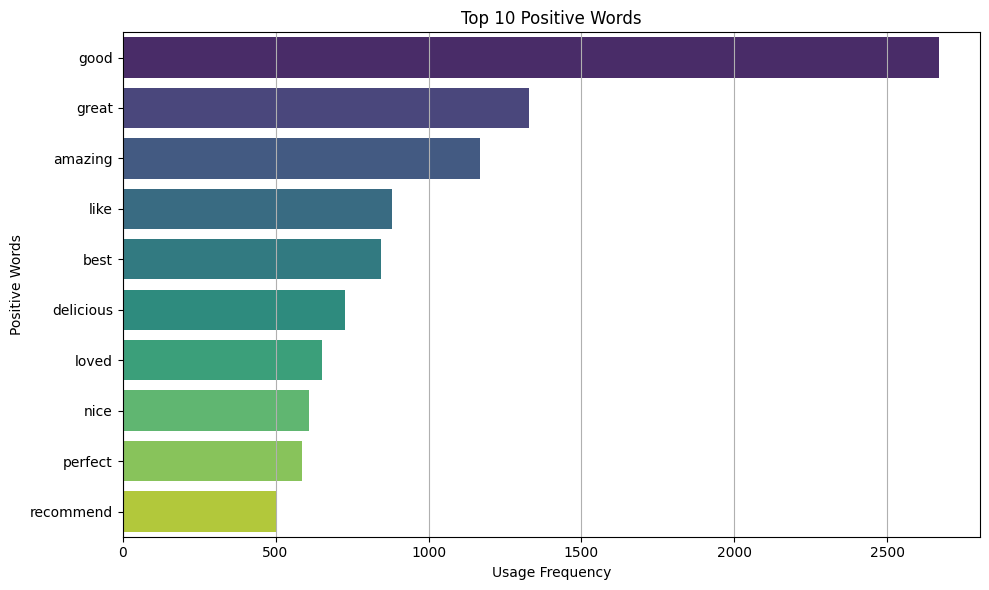

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(data=positive_word_counts.sort_values(by='count', ascending=False).head(10),
            x='count', y='word', palette='viridis')
plt.title('Top 10 Positive Words')
plt.xlabel('Usage Frequency')
plt.ylabel('Positive Words')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Mostly Used Negative Sentiment Words in User Reviews

In [21]:
negative_words = []
for review in positive_reviews_text:
    words = word_tokenize(review.lower())
    negative_words.extend(words)

negative_words_filtered = [word for word in negative_words if sid.polarity_scores(word)['neg'] > 0]
negative_word_counts = pd.DataFrame(Counter(negative_words_filtered).most_common(), columns=['word', 'count'])

C:\Users\ama.D.eus\AppData\Local\Temp\ipykernel_17420\854195851.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=negative_word_counts.sort_values(by='count', ascending=False).head(10),


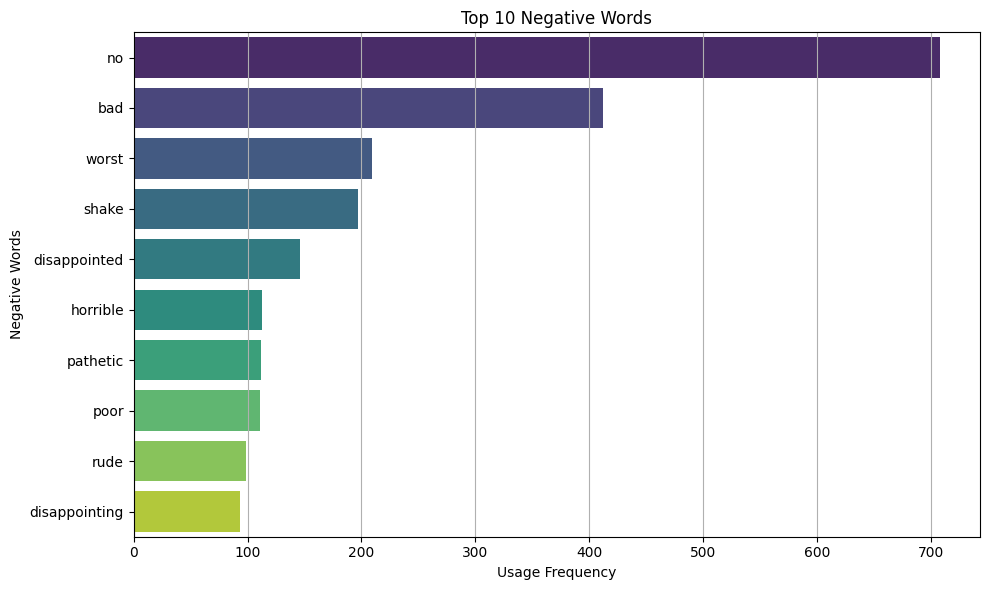

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(data=negative_word_counts.sort_values(by='count', ascending=False).head(10),
            x='count', y='word', palette='viridis')
plt.title('Top 10 Negative Words')
plt.xlabel('Usage Frequency')
plt.ylabel('Negative Words')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [25]:
with open('positive_words.txt', 'w') as pos_file:
    for word in positive_words_filtered:
        pos_file.write(f"{word}\n")

# Write negative words to a text file
with open('negative_words.txt', 'w') as neg_file:
    for word in negative_words_filtered:
        neg_file.write(f"{word}\n")